In [1]:
# PyTorch
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.models as models
from torchvision import datasets, transforms
from torch.utils import data

# To Read Data
from torch.utils.data import Dataset, DataLoader
import numpy as np
from PIL import Image
# To Interpret results & obtain plots
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score, accuracy_score, roc_curve, auc
import matplotlib.pyplot as plt

# You could add your own libraries from Python Standard Library in this cell. Any other external libraries are not allowed.
import os

In [2]:
class ChestDataset(Dataset):
    def __init__(self, **kwargs):
        self.path = kwargs.get('path')
        self.transform = kwargs.get('transform')
        self.data = datasets.ImageFolder(self.path, transform=self.transform)
        self.path_label_list = self.data.imgs


    '''This function should return sample count in the dataset'''
    def __len__(self):
        return len(self.data)

    '''This function should return a single sample and its ground truth value from the dataset corresponding to index parameter '''
    def __getitem__(self, index):
        # Load image and label from the dataset based on the index
        image_path, label = self.path_label_list[index]

        try:
            image = Image.open(image_path).convert("RGB")
        except Exception as e:
            print(f"Error loading image: {image_path}, {e}")
            return None, None

        # print("Image size before transformation:", image.size)

        # Optionally apply transformations
        if self.transform:
            image = self.transform(image)

        # print("Image size after transformation:", image.shape)

        return image, label

def get_dataset(root):
    # Define transformations for the images
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
    ])

    # Load datasets for training, validation, and test with size (224, 224)
    dataset = ChestDataset(path=root, transform=transform)

    # Compute mean and std for normalization
    def compute_mean_and_std(dataset):
        mean_sum = np.zeros(3)
        std_sum = np.zeros(3)
        num_samples = len(dataset)

        for img, _ in dataset:
            img = np.array(img)
            # Compute mean along height and width axes
            img_mean = np.mean(img, axis=(1, 2))
            # Compute std along height and width axes
            img_std = np.std(img, axis=(1, 2))

            mean_sum += img_mean
            std_sum += img_std

        # Compute overall mean and std across all images
        mean = mean_sum / num_samples
        std = std_sum / num_samples

        return mean, std

    train_mean, train_std = compute_mean_and_std(dataset)

    # Apply normalization with computed mean and std
    transform = transforms.Compose([
        transform,
        transforms.Normalize(mean=train_mean, std=train_std)
    ])

    # Apply normalization to datasets
    dataset.transform = transform

    return dataset

In [3]:
def get_loaders(data_foldername, train_batch = 64, test_batch = 64, val_batch = 64):
    # Create the full dataset
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dataset = get_dataset(dataset_path)

    # Assume each data point is a tuple (image, label) and collect the labels
    labels = [label for _, label in dataset]

    # Generate indices: full range of dataset
    full_indices = list(range(len(dataset)))

    # First split: separate out the test set
    train_val_indices, test_indices = train_test_split(
    full_indices, test_size=0.1, stratify=labels, random_state=42
    )

    # Adjust the labels and indices for the next split by filtering out test indices
    train_val_labels = [labels[i] for i in train_val_indices]

    # Second split: split the remaining data into train and validation sets
    train_indices, val_indices = train_test_split(
    train_val_indices, test_size=(0.1 / 0.9), stratify=train_val_labels, random_state=42
    )

    # Create subsets for train, validation, and test
    train_dataset = data.Subset(dataset, train_indices)
    val_dataset = data.Subset(dataset, val_indices)
    test_dataset = data.Subset(dataset, test_indices)

    # Create dataset loaders
    train_loader = DataLoader(dataset=train_dataset, batch_size=train_batch, shuffle=True)
    test_loader = DataLoader(dataset=test_dataset, batch_size=test_batch)
    val_loader = DataLoader(dataset=val_dataset, batch_size=val_batch)

    return train_loader, test_loader, val_loader

def get_num_of_classes(data_foldername):
    dataset_path = os.path.join(os.getcwd(), data_foldername)
    dummy_dataset = ChestDataset(path=dataset_path)
    num_of_classes = len(dummy_dataset.data.classes)

    return num_of_classes

def train_for_epoch(model, train_loader, loss_fn, optimizer, device):
    model.train()
    running_loss = 0.0
    total = 0
    correct = 0
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = loss_fn(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return running_loss / len(train_loader), accuracy

def validate_for_epoch(model, val_loader, loss_fn, device):
    model.eval()
    total = 0
    correct = 0
    val_loss = 0.0
    with torch.no_grad():
        for images, labels in val_loader:
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            loss = loss_fn(outputs, labels)
            val_loss += loss.item()
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    accuracy = correct / total
    return val_loss / len(val_loader), accuracy

def train(model, train_loader, val_loader, loss_function, optimizer, max_epoch, device, best_model_path):
    best_val_loss = float('inf')
    train_losses = []
    train_accuracies = []
    val_losses = []
    val_accuracies = []

    for epoch in range(max_epoch):
        # Training
        train_loss, train_accuracy = train_for_epoch(model, train_loader, loss_function, optimizer, device)
        train_losses.append(train_loss)
        train_accuracies.append(train_accuracy)  # Corrected variable name

        # Validation
        val_loss, val_accuracy = validate_for_epoch(model, val_loader, loss_function, device)
        val_losses.append(val_loss)
        val_accuracies.append(val_accuracy)

        print(f'Epoch [{epoch + 1}/{max_epoch}], Train Loss: {train_loss:.4f}, Train Accuracy: {train_accuracy:.4f}, Val Loss: {val_loss:.4f}, Val Accuracy: {val_accuracy:.4f}')

        # Save best model according to validation performance
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), best_model_path)

        # if val_accuracy < val_accuracy:
        #     best_val_acc = val_accuracy
        #     torch.save(model.state_dict(), best_model_path)


    history = {'train_losses': train_losses, 'train_accuracies': train_accuracies, 'val_losses': val_losses, 'val_accuracies': val_accuracies}

    return history

def plot_losses(history):
    plt.plot(history['train_losses'], label='Train Loss')
    plt.plot(history['val_losses'], label='Val Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Losses vs Epoch')
    plt.legend()
    plt.show()

def plot_accuracies(history):
    plt.plot(history['train_accuracies'], label='Train Accuracy')
    plt.plot(history['val_accuracies'], label='Val Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy vs Epoch')
    plt.legend()
    plt.show()

def load_best_model(model_path):
    state_dict = torch.load(model_path)
    # Instantiate your model
    model = CNN()
    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def load_best_model_transfer(model_path, data_foldername):
    state_dict = torch.load(model_path)

    # Instantiate your model
    model = models.resnet18(weights=models.ResNet18_Weights.IMAGENET1K_V1)
    num_features = model.fc.in_features
    num_classes = get_num_of_classes(data_foldername)
    model.fc = nn.Linear(num_features, num_classes)

    # Load state dictionary into model
    model.load_state_dict(state_dict)

    return model

def test_model(model, test_loader, device):
    model.eval()
    loss_func = nn.CrossEntropyLoss()

    all_predictions = []
    all_targets = []
    all_losses = []
    all_probs = [] # for roc-auc

    # Move model to device
    model.to(device)

    # Disable gradients for evaluation
    with torch.no_grad():
        for images, targets in test_loader:
            # Move images and targets to device
            images = images.to(device)
            targets = targets.to(device)
            # Forward pass
            outputs = model(images)
            # Compute loss
            loss = loss_func(outputs, targets)
            all_losses.append(loss.item())

            _, predicted = torch.max(outputs, 1)
            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            # Get probabilities
            softmax = torch.nn.Softmax(dim=1)
            probs = softmax(outputs)
            all_probs.extend(probs.cpu().numpy())

    # Convert targets and predictions to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)
    all_probs = np.array(all_probs)

    return all_losses, all_predictions, all_targets, all_probs

def calculate_metrics(all_losses, all_predictions, all_targets):
    # Calculate evaluation metrics
    mean_loss = np.mean(all_losses)
    acc = accuracy_score(all_targets, all_predictions)
    pre = precision_score(all_targets, all_predictions, average='macro', zero_division=0)
    recall = recall_score(all_targets, all_predictions, average='macro', zero_division=0)
    f1 = f1_score(all_targets, all_predictions, average='macro')

    # Return metric results as a dictionary
    metrics = {
        'mean_loss': mean_loss,
        'accuracy': acc,
        'precision': pre,
        'recall': recall,
        'f1_score': f1
    }

    return metrics

def plot_confusion_matrix(conf_matrix):
    plt.imshow(conf_matrix, cmap='Blues', interpolation='nearest')
    plt.title("Confusion Matrix")
    plt.colorbar()
    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    for i in range(len(classes)):
        for j in range(len(classes)):
            plt.text(j, i, format(conf_matrix[i, j], 'd'), horizontalalignment="center", color="black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()
    plt.show()

def plot_roc_auc(targets, probs):
    num_classes = probs.shape[1]
    plt.figure(figsize=(8, 6))

    classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
    for i in range(num_classes):
        # Create binary target for the current class
        binary_targets = np.array(targets == i, dtype=int)
        fpr, tpr, _ = roc_curve(binary_targets, probs[:, i])
        roc_auc = auc(fpr, tpr)
        plt.plot(fpr, tpr, label='ROC curve ({}) (AUC = {:.2f})'.format(classes[i], roc_auc))
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve')
    plt.legend(loc="lower right")
    plt.show()

In [4]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report

from skimage.feature import hog
import numpy as np
import cv2
from sklearn.model_selection import train_test_split, GridSearchCV

data_foldername = '../dataFolder'

dataset_path = os.path.join(os.getcwd(), data_foldername)
dataset = get_dataset(dataset_path)

# Extract HOG features from images
X = []
y = []

for img, label in dataset:
    img_np = np.array(img.permute(1, 2, 0))  # Convert PyTorch tensor to NumPy array and transpose channels
    img_gray = cv2.cvtColor(img_np, cv2.COLOR_RGB2GRAY)
    hog_features = hog(img_gray, orientations=9, pixels_per_cell=(8, 8), cells_per_block=(2, 2), visualize=False)
    X.append(hog_features)
    y.append(label)

# Convert to numpy arrays
X = np.array(X)
y = np.array(y)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



# Define decision tree with Gini index and max depth 10
tree = DecisionTreeClassifier(criterion='gini', max_depth= None, max_features= 'sqrt', min_samples_leaf= 2, min_samples_split = 5)

# Define AdaBoost classifier without specifying base_estimator
classifier = AdaBoostClassifier(estimator=tree, algorithm='SAMME.R')

# Define parameter grid
param_grid = {
    'n_estimators': [50, 100, 150],
    'learning_rate': [0.1, 0.5, 1.0]
}

# Perform grid search
grid_search = GridSearchCV(classifier, param_grid, cv=3, n_jobs=-1, verbose=1)
grid_search.fit(X_train, y_train)

# Print best parameters and corresponding score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Make predictions on the test data using the best estimator found by grid search
y_pred = grid_search.best_estimator_.predict(X_test)


# Best Parameters: {'learning_rate': 0.5, 'n_estimators': 50}
# Best Score: 0.29378220832981333

Fitting 3 folds for each of 9 candidates, totalling 27 fits


/home/innsolit/miniconda3/envs/torchenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/innsolit/miniconda3/envs/torchenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/innsolit/miniconda3/envs/torchenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/innsolit/miniconda3/envs/torchenv/lib/python3.10/site-packages/sklearn/ensemble/_weight_boosting.py:519: FutureWarning: The SAMME.R algorithm (the default) is deprecated and w

Best Parameters: {'learning_rate': 0.1, 'n_estimators': 150}
Best Score: 0.31627289196774705


In [5]:
# # Create an AdaBoost classifier
# classifier = AdaBoostClassifier(learning_rate=0.5, n_estimators=50)

# # Fit the classifier to the training data
# classifier.fit(X_train, y_train)

# # Make predictions on the test data
# y_pred = classifier.predict(X_test)

Accuracy: 0.3150
Macro Precision: 0.3111
Macro Recall: 0.3245
Macro F1 Score: 0.3098


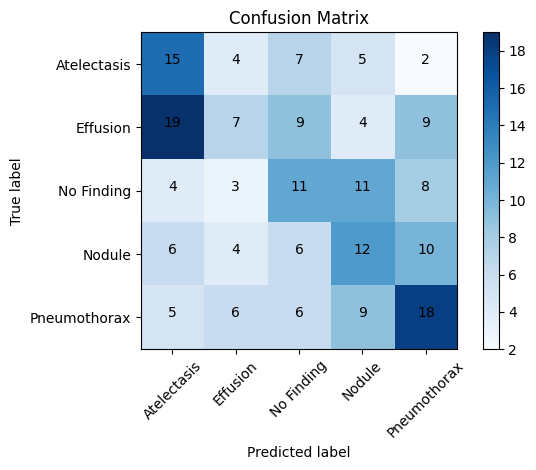

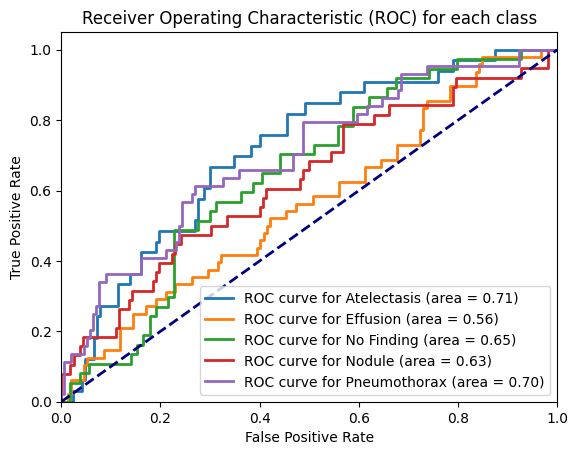

In [6]:
acc = accuracy_score(y_test, y_pred)
pre = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# Return metric results as a dictionary
metrics = {
    'accuracy': acc,
    'precision': pre,
    'recall': recall,
    'f1_score': f1
}


# Print metrics
print("Accuracy: {:.4f}\nMacro Precision: {:.4f}\nMacro Recall: {:.4f}\nMacro F1 Score: {:.4f}".format(
    metrics['accuracy'], metrics['precision'], metrics['recall'], metrics['f1_score']))

# plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plot_confusion_matrix(conf_matrix)




from sklearn.preprocessing import label_binarize

# Convert y_test to binary format
y_test_bin = label_binarize(y_test, classes=np.unique(y_test))

# Get the probabilities for each class
y_prob = grid_search.best_estimator_.predict_proba(X_test)

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(len(np.unique(y_test))):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_prob[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Plot ROC curves for each class
plt.figure()
lw = 2
classes = ['Atelectasis', 'Effusion', 'No Finding', 'Nodule', 'Pneumothorax']
for i in range(len(np.unique(y_test))):
    plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve for {} (area = {:.2f})'.format(classes[i], roc_auc[i]))

plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) for each class')
plt.legend(loc="lower right")
plt.show()